In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd

In [11]:
def MEG_gradient(X, time, N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_overall_conc, Pase_grad, PLK1_overall_conc, PLK1_grad):
    
    x=2*PLK1_overall_conc/(2-PLK1_grad)
    PLK_conc = np.linspace((1-PLK1_grad)*x, x, N)
    
    x=2*Pase_overall_conc/(2-Pase_grad)
    Pase_conc = np.linspace(x,(1-Pase_grad)*x, N)
    
    dx=np.zeros(4*N)
    
    # equations for M - dx[0 to N-1] is M conc in cpts 0 to N-1
    for i in range(N):
        
        if i==0:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i+1]-X[i])
        
        elif i==N-1:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i-1]-X[i])
            
        else:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i+1]+X[i-1]-2*X[i]) 
    
    # equations for MP - dx[N to 2N-1] is M conc in cpts 0 to N-1
    
    for i in range(N):
        
        if i==0:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N+1]-X[i+N])
        
        elif i==N-1:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N-1]-X[i+N])
            
        else:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N+1]+X[i+N-1]-2*X[i+N]) 
    
    # equations for R - dx[2*N to 3N-1] is R conc in cpts 0 to N-1
    
    for i in range(N):
        
        dx[i+2*N]=-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+kcat2_km2*PLK_conc[i]*X[i+3*N]
        
    
    # equations for MR - dx[3*N to 4N-1] is MR conc in cpts 0 to N-1
    
    for i in range(N):
        
        if i==0:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N+1]-X[i+3*N])
        
        elif i==N-1:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N-1]-X[i+3*N])
            
        else:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N+1]+X[i+3*N-1]-2*X[i+3*N]) 
    
    return dx

Text(0.5, 1.0, 'SD gradient over time')

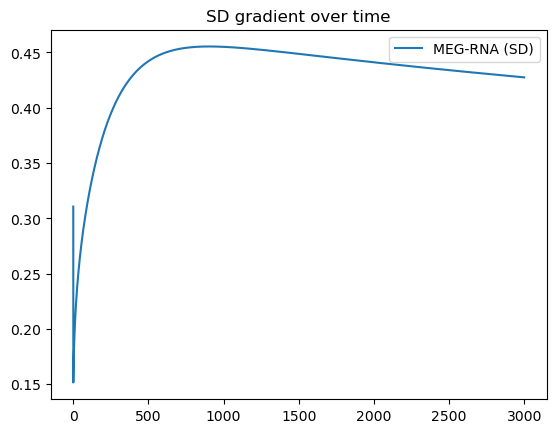

In [58]:
# PLK-1 KO - most consistent with combining with RNA competition

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=150
RNA_grad=0.52
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
  
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.25
PLK1_conc=0
PLK1_grad=0.25
kcat_km=1.8*10**(-4)

params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
sol=odeint(MEG_gradient, init, t, params) 

posterior_SD = sol[1:, 3*N]
anterior_SD = sol[1:, 4*N-1]
SD_gradient_strength=1-anterior_SD/posterior_SD

plt.plot(t[1:], SD_gradient_strength, label="MEG-RNA (SD)")
plt.legend(loc='best')
plt.title("SD gradient over time")

Text(0.5, 1.0, 'SD gradient over time')

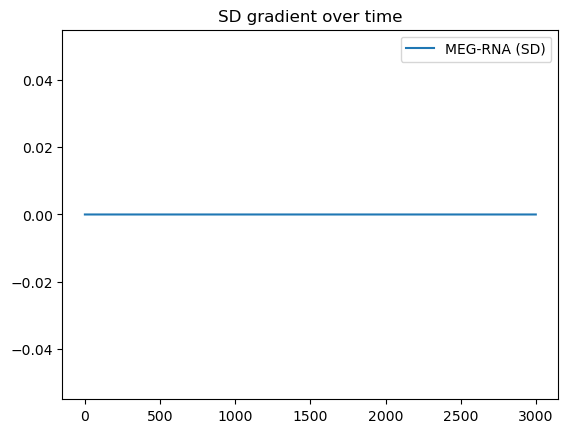

In [57]:
# PLK-1 symmetric and RNA symmetric - mimicking MEX-5 KO
# still get SD gradient, unless set phosphatase gradient to 0 too
# could be that MEX-5 somehow inhibits phosphatase activity rather than the phosphatase itself being polarised -> in that case, model phosphatase with
# inverse gradient to MEX-5 (0.52 but in other direction)

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=150
RNA_grad=0.52
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
  
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0
kcat_km=1.8*10**(-4)

params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
sol=odeint(MEG_gradient, init, t, params) 

posterior_SD = sol[1:, 3*N]
anterior_SD = sol[1:, 4*N-1]
SD_gradient_strength=1-anterior_SD/posterior_SD

plt.plot(t[1:], np.round(SD_gradient_strength), label="MEG-RNA (SD)")
plt.legend(loc='best')
plt.title("SD gradient over time")

Text(0.5, 1.0, 'SD gradient over time')

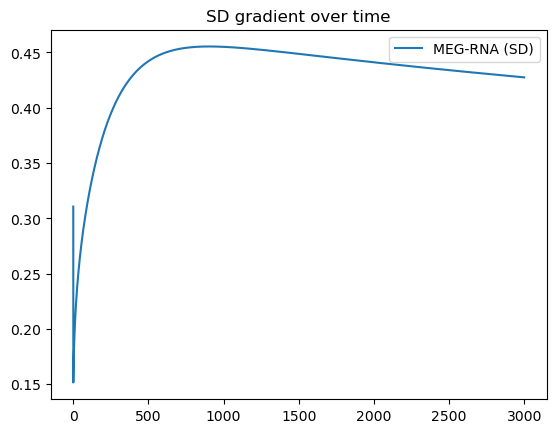

In [54]:
# redoing PLK-1 KO with phosphatase polarised according to MEX-5
# SD grad is weakened compared to WT (see below), though not as much as in reality (expect about 36% grad)

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=150
RNA_grad=0.52
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
  
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.52
PLK1_conc=0
PLK1_grad=0.25
kcat_km=1.8*10**(-4)

params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
sol=odeint(MEG_gradient, init, t, params) 

posterior_SD = sol[1:, 3*N]
anterior_SD = sol[1:, 4*N-1]
SD_gradient_strength=1-anterior_SD/posterior_SD

plt.plot(t[1:], SD_gradient_strength, label="MEG-RNA (SD)")
plt.legend(loc='best')
plt.title("SD gradient over time")

IndexError: list index out of range

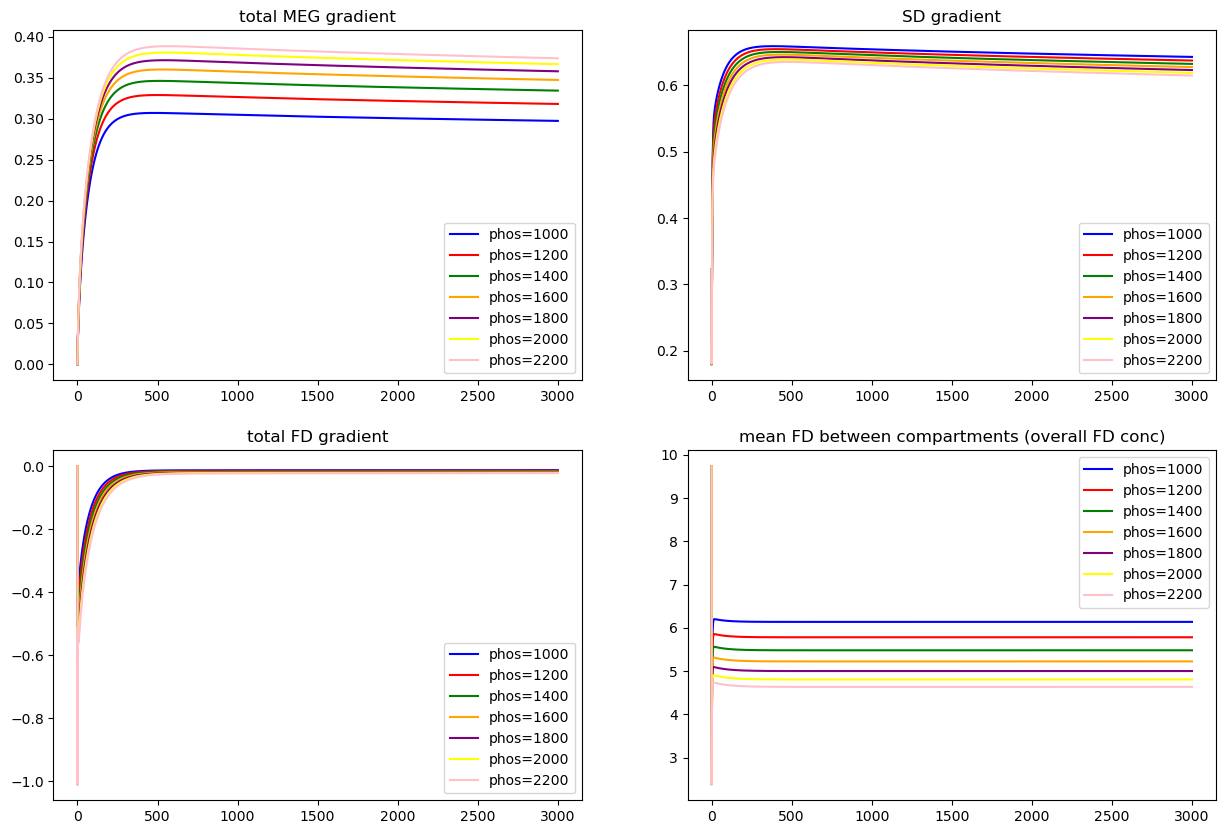

In [46]:
# equal and oppposite gradient for (active) Pase to the RNA, i.e. to MEX-5
# gets pretty close to the literature SD gradient of 71 ish percent (Wu et al.)

# varying phosphatase conc doesn't have much effect on SD gradient - increasing it decreases the SD grad, but increases the total grad
# not sure which value to pick then...

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=150
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
  
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'pink']

for count, phos_conc in enumerate(range(1000, 2600, 200)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"phos={phos_conc}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_conc !=0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos={phos_conc}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos={phos_conc}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos={phos_conc}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)

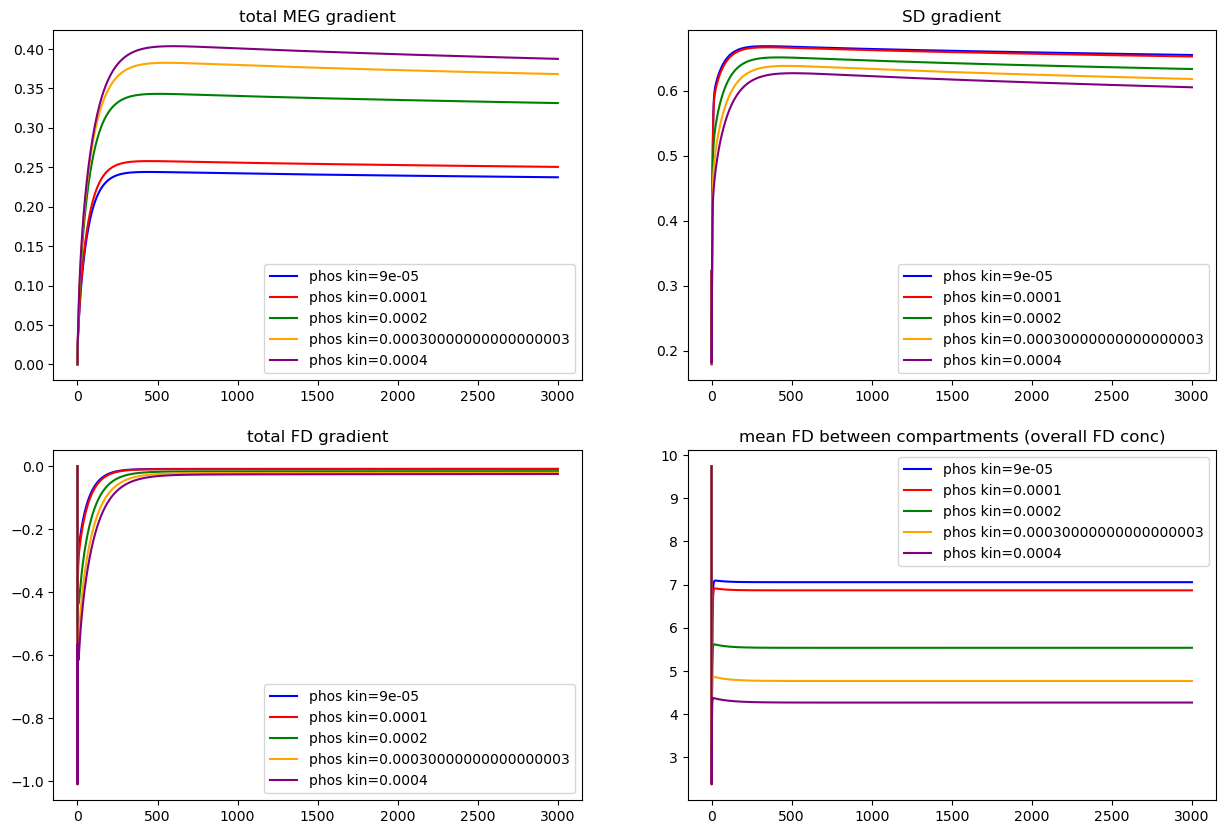

In [49]:
# equal and oppposite gradient for (active) Pase to the RNA, i.e. to MEX-5
# gets pretty close to the literature SD gradient of 71 ish percent (Wu et al.)

# varying phosphatase kinetics - decreasing it increases the SD grad (in the range of the values tested here), but at the expense of the total grad
# not sure which value to pick then...

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'pink']

for count, phos_kinetics in enumerate((9*10**(-5), 1*10**(-4), 2*10**(-4), 3*10**(-4), 4*10**(-4))):
    params=(N, phos_kinetics, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"phos kin={phos_kinetics}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_conc !=0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos kin={phos_kinetics}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos kin={phos_kinetics}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos kin={phos_kinetics}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)